# Part II: Implementing ResNet Architecture

### **<span style="color:Teal">The code snippets used here are derived from my submission for the CSE 574 D Introduction to ML course, Fall 2023, titled bhanucha_hkongara_Assignment_2</span>**

- Load the necessary lib

In [1]:
!pip install torchinfo

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from torchinfo import summary
import torch.nn.functional as F
import plotly
import scipy.stats as stats
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

import pickle
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import time
from torch.utils.data import Dataset, DataLoader

import os
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from PIL import Image
from collections import Counter
from torchsummary import summary
import random


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

!unzip '/content/drive/MyDrive/DL/cnn_dataset.zip' -d '/content/dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/vehicles/5499.jpg  
  inflating: /content/dataset/vehicles/55.jpg  
  inflating: /content/dataset/vehicles/550.jpg  
  inflating: /content/dataset/vehicles/5500.jpg  
  inflating: /content/dataset/vehicles/5501.jpg  
  inflating: /content/dataset/vehicles/5502.jpg  
  inflating: /content/dataset/vehicles/5503.jpg  
  inflating: /content/dataset/vehicles/5504.jpg  
  inflating: /content/dataset/vehicles/5505.jpg  
  inflating: /content/dataset/vehicles/5506.jpg  
  inflating: /content/dataset/vehicles/5507.jpg  
  inflating: /content/dataset/vehicles/5508.jpg  
  inflating: /content/dataset/vehicles/5509.jpg  
  inflating: /content/dataset/vehicles/551.jpg  
  inflating: /content/dataset/vehicles/5510.jpg  
  inflating: /content/dataset/vehicles/5511.jpg  
  inflating: /content/dataset/vehicles/5512.jpg  
  inflating: /content/dataset/vehicles/5513.jpg  
  inflating: /content/dataset/vehicles/5514.jpg  
  i

In [5]:
dataset_path = '/content/dataset'

In [6]:
transform_data_n = transforms.Compose([
    transforms.Resize((64, 64)),                # Resize the image to 64x64
    transforms.ToTensor(),                     # Convert image to tensor
    # transforms.Normalize(mean=mean, std=std)   # Normalize image using calculated mean and std
])

# Create dataset with normalization
dataset = datasets.ImageFolder(dataset_path, transform=transform_data_n)

In [7]:
print("Number of images in the dataset", len(dataset))
print("Classes", dataset.classes)

Number of images in the dataset 30000
Classes ['dogs', 'food', 'vehicles']


In [8]:
sample_image, _ = dataset[0]
image_height, image_width = sample_image.shape[-2], sample_image.shape[-1]
print("Image size", image_height, "-", image_width)

Image size 64 - 64


In [9]:
n_chan = sample_image.shape[0]
print("Number of channels:", n_chan)

Number of channels: 3


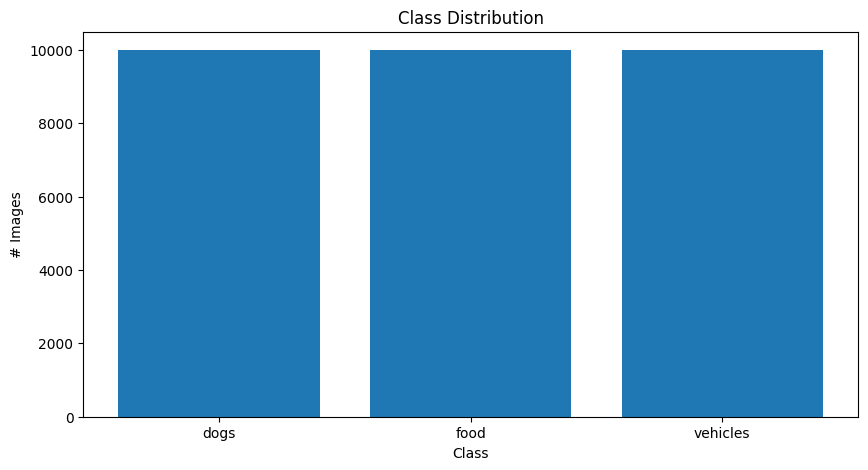

In [10]:
class_counts = np.bincount(dataset.targets)
class_labels = dataset.classes

plt.figure(figsize=(10, 5))
plt.bar(class_labels, class_counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('# Images')
plt.show()


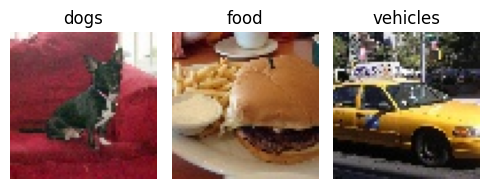

In [11]:

class_labels = dataset.classes
plt.figure(figsize=(5, 5))


for i, class_label in enumerate(class_labels):
    class_indices = np.where(np.array(dataset.targets) == i)[0]
    first_image_index = class_indices[0]
    sample_image, _ = dataset[first_image_index]

    # Display the image
    plt.subplot(1, len(class_labels), i + 1)
    plt.imshow(sample_image.permute(1, 2, 0))
    plt.title(class_label)
    plt.axis('off')

plt.tight_layout()
plt.show()


- SPlit the dataset

In [12]:
training_data_length = int(len(dataset) * 0.750)
train_data, temp = torch.utils.data.random_split(dataset, [training_data_length, len(dataset) - training_data_length])

In [13]:
vdata_length = int(len(temp) * 0.5)
valid_data, test_data = torch.utils.data.random_split(temp, [vdata_length, len(temp) - vdata_length])

In [14]:
batch_size = 32

In [15]:
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(valid_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 22500
Validation set size: 3750
Test set size: 3750


In [16]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Define the RESNET 18

In [17]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, channel_in, c_out, stride, downsample=None):
        super(ResidualBlock, self).__init__()

        self.rone = nn.Sequential(
            nn.Conv2d(channel_in, c_out, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True))

        self.rtwo = nn.Sequential(
            nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(c_out))

        self.downsample = downsample

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x

        out = self.rone(x)
        out = self.rtwo(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out



In [18]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, planes, blocks, stride=1):
        downsample = None

        if stride != 1 or self.in_channels != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes))

        layers = []
        layers.append(block(self.in_channels, planes, stride, downsample))
        self.in_channels = planes
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, planes, stride=1))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



In [19]:
classes = 3


# Create ResNet-18 model
def resnet18(classes):
    return ResNet(ResidualBlock, [2, 2, 2, 2], classes)

# Test the model
model = resnet18(classes)
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (rone): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (rtwo): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (rone): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05

In [20]:

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

In [21]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, (3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,928
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
    ResidualBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,928
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

### Functions to train and evaluate model, taken from the reference

In [ ]:
def train_model(model, train_loader, valid_loader, optimizer, criterion, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        total_train_loss = 0
        train_predictions = []
        train_targets = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            train_predictions.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_accuracy = accuracy_score(train_targets, train_predictions)
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        total_valid_loss = 0
        valid_predictions = []
        valid_targets = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_valid_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                valid_predictions.extend(predicted.cpu().numpy())
                valid_targets.extend(labels.cpu().numpy())

            valid_accuracy = accuracy_score(valid_targets, valid_predictions)
            avg_valid_loss = total_valid_loss / len(valid_loader)
            valid_losses.append(avg_valid_loss)
            valid_accuracies.append(valid_accuracy)

        end_time = time.time()
        epoch_time = end_time - start_time
        print(f"Epoch {epoch + 1}/{num_epochs} took {epoch_time:.2f} seconds. "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {avg_valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    return train_losses, train_accuracies, valid_losses, valid_accuracies

In [ ]:
num_epochs = 10
device = 'cuda'
train_losses, train_accuracies, valid_losses, valid_accuracies = train_model(model, train_loader, valid_loader, optimizer, criterion, num_epochs)

Epoch 1/10 took 43.47 seconds. Train Loss: 0.4640, Train Accuracy: 0.8221, Validation Loss: 0.3483, Validation Accuracy: 0.8701
Epoch 2/10 took 37.89 seconds. Train Loss: 0.3297, Train Accuracy: 0.8785, Validation Loss: 0.3357, Validation Accuracy: 0.8696
Epoch 3/10 took 38.01 seconds. Train Loss: 0.2768, Train Accuracy: 0.8969, Validation Loss: 0.2609, Validation Accuracy: 0.9048
Epoch 4/10 took 38.14 seconds. Train Loss: 0.2446, Train Accuracy: 0.9107, Validation Loss: 0.5189, Validation Accuracy: 0.8005
Epoch 5/10 took 37.79 seconds. Train Loss: 0.2215, Train Accuracy: 0.9159, Validation Loss: 0.3313, Validation Accuracy: 0.8749
Epoch 6/10 took 38.10 seconds. Train Loss: 0.1989, Train Accuracy: 0.9247, Validation Loss: 0.2119, Validation Accuracy: 0.9264
Epoch 7/10 took 38.07 seconds. Train Loss: 0.1757, Train Accuracy: 0.9366, Validation Loss: 0.3137, Validation Accuracy: 0.8960
Epoch 8/10 took 38.11 seconds. Train Loss: 0.1644, Train Accuracy: 0.9380, Validation Loss: 0.2203, Vali

In [25]:

def evaluate_model(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_losses = []
    test_predictions = []
    test_targets = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            test_predictions.extend(predicted.cpu().numpy())
            test_targets.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(test_targets, test_predictions)
    test_f1 = f1_score(test_targets, test_predictions, average='weighted')
    test_precision = precision_score(test_targets, test_predictions, average='weighted')
    test_recall = recall_score(test_targets, test_predictions, average='weighted')
    test_loss = np.mean(test_losses)

    return test_accuracy, test_f1, test_precision, test_recall, test_loss,  test_targets, test_predictions


In [ ]:
# Call evaluate_model to calculate test metrics
test_accuracy, test_f1, test_precision, test_recall, test_loss, test_targets, test_predictions = evaluate_model(model, test_loader, criterion)

# Print test metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Loss: {test_loss:.4f}")

Test Accuracy: 0.9248
F1 Score: 0.9243
Precision: 0.9259
Recall: 0.9248
Loss: 0.2225


- TRAINING VS VALIDATION ACCURACY

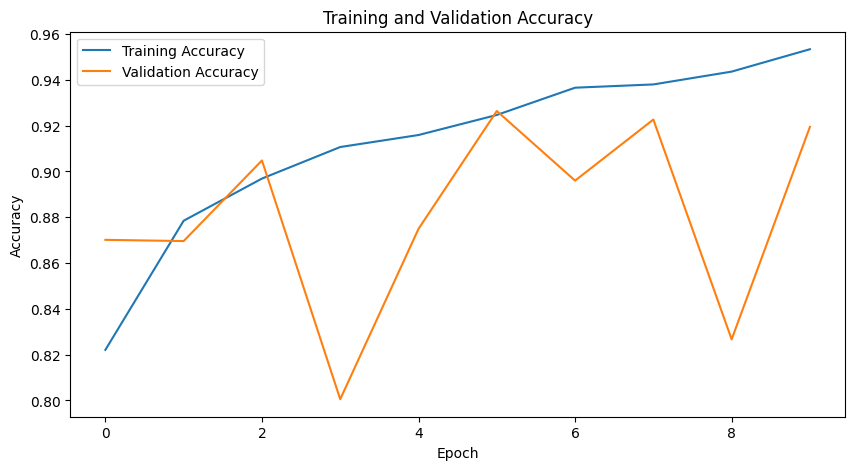

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


- TRAINING VS VALIDATION LOSS

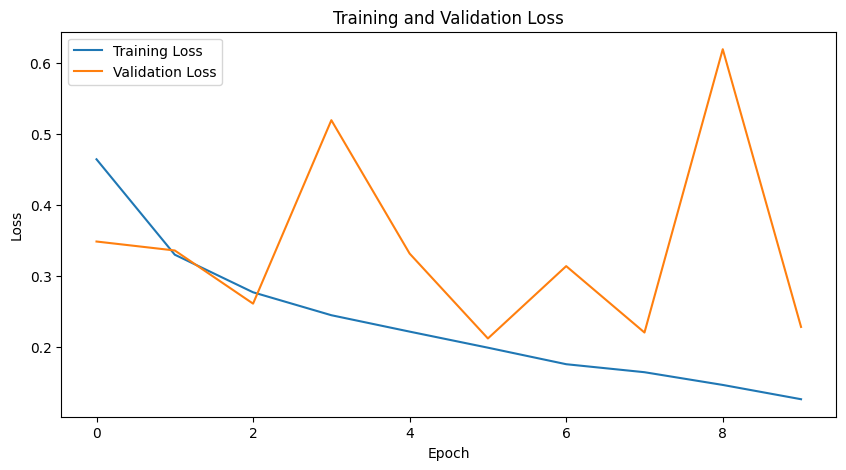

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


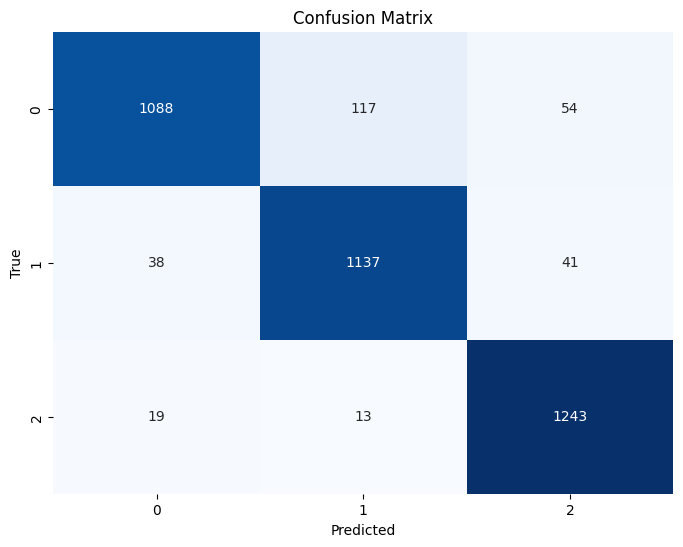

Precision: 0.9259
Recall: 0.9248
F1 Score: 0.9243


In [ ]:
conf_matrix = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(test_targets, test_predictions, average='weighted')
recall = recall_score(test_targets, test_predictions, average='weighted')
f1 = f1_score(test_targets, test_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

## Apply Dorp out

In [ ]:
class ResNet_d(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet_d, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2))  # DROP OUT ADDES

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, planes, blocks, stride=1):
        downsample = None

        if stride != 1 or self.in_channels != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
                nn.Dropout(0.5))  # DROP OUT ADDES

        layers = []
        layers.append(block(self.in_channels, planes, stride, downsample))
        self.in_channels = planes
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, planes, stride=1))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



In [ ]:
classes = 3


# Create ResNet-18 model
def resnet18_d(classes):
    return ResNet_d(ResidualBlock, [2, 2, 2, 2], classes)

# Test the model
model = resnet18_d(classes)

In [ ]:

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



ResNet_d(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (rone): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (rtwo): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (rone): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [ ]:
num_epochs = 10
device = 'cuda'
train_losses, train_accuracies, valid_losses, valid_accuracies = train_model(model, train_loader, valid_loader, optimizer, criterion, num_epochs)

Epoch 1/10 took 42.06 seconds. Train Loss: 0.4632, Train Accuracy: 0.8217, Validation Loss: 0.3391, Validation Accuracy: 0.8691
Epoch 2/10 took 39.66 seconds. Train Loss: 0.3307, Train Accuracy: 0.8757, Validation Loss: 0.4803, Validation Accuracy: 0.8197
Epoch 3/10 took 40.25 seconds. Train Loss: 0.2967, Train Accuracy: 0.8893, Validation Loss: 0.3062, Validation Accuracy: 0.8789
Epoch 4/10 took 38.39 seconds. Train Loss: 0.2536, Train Accuracy: 0.9056, Validation Loss: 0.2766, Validation Accuracy: 0.9027
Epoch 5/10 took 40.96 seconds. Train Loss: 0.2226, Train Accuracy: 0.9176, Validation Loss: 0.4893, Validation Accuracy: 0.8240
Epoch 6/10 took 38.36 seconds. Train Loss: 0.2133, Train Accuracy: 0.9204, Validation Loss: 0.4463, Validation Accuracy: 0.8371
Epoch 7/10 took 38.43 seconds. Train Loss: 0.1922, Train Accuracy: 0.9288, Validation Loss: 0.2746, Validation Accuracy: 0.9011
Epoch 8/10 took 38.75 seconds. Train Loss: 0.1765, Train Accuracy: 0.9332, Validation Loss: 0.1988, Vali

In [ ]:
# Call evaluate_model to calculate test metrics
test_accuracy, test_f1, test_precision, test_recall, test_loss, test_targets, test_predictions = evaluate_model(model, test_loader, criterion)

# Print test metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Loss: {test_loss:.4f}")

Test Accuracy: 0.9301
F1 Score: 0.9305
Precision: 0.9322
Recall: 0.9301
Loss: 0.2000


- TRAINING VS VALIDATION ACCURACY

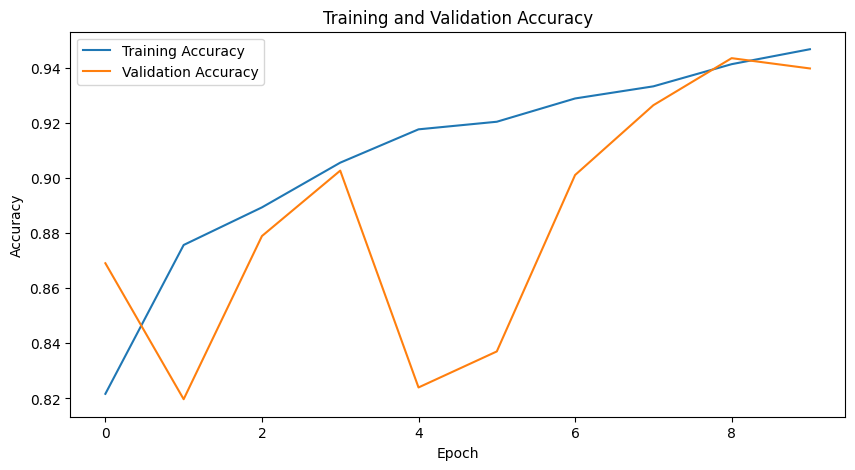

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


- TRAINING VS VALIDATION LOSS

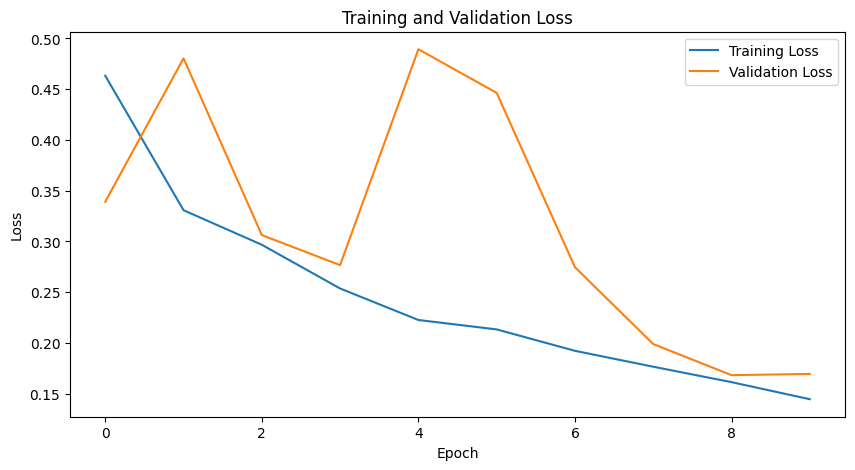

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


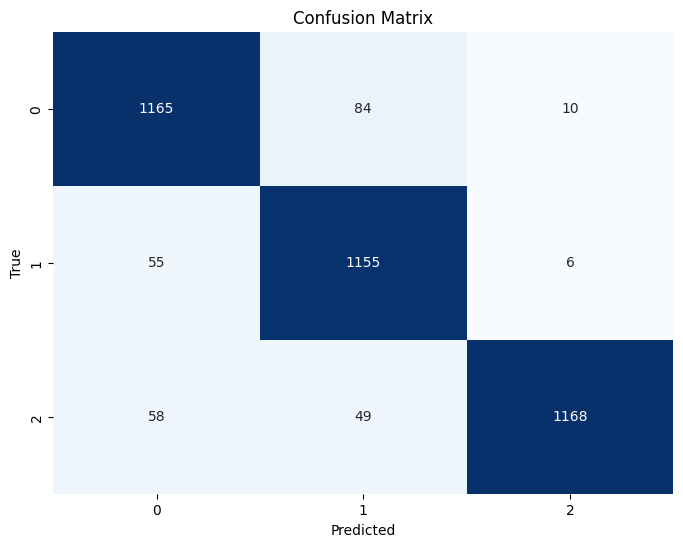

Precision: 0.9322
Recall: 0.9301
F1 Score: 0.9305


In [ ]:
conf_matrix = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(test_targets, test_predictions, average='weighted')
recall = recall_score(test_targets, test_predictions, average='weighted')
f1 = f1_score(test_targets, test_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

## Apply EARLY STOPPING

In [22]:
import torch
from sklearn.metrics import accuracy_score
import time

def train_model(model, train_loader, valid_loader, optimizer, criterion, num_epochs, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    best_valid_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        total_train_loss = 0
        train_predictions = []
        train_targets = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            train_predictions.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_accuracy = accuracy_score(train_targets, train_predictions)
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        total_valid_loss = 0
        valid_predictions = []
        valid_targets = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_valid_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                valid_predictions.extend(predicted.cpu().numpy())
                valid_targets.extend(labels.cpu().numpy())

            valid_accuracy = accuracy_score(valid_targets, valid_predictions)
            avg_valid_loss = total_valid_loss / len(valid_loader)
            valid_losses.append(avg_valid_loss)
            valid_accuracies.append(valid_accuracy)

            # Check for early stopping
            if avg_valid_loss < best_valid_loss:
                best_valid_loss = avg_valid_loss
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if early_stopping_counter >= patience:
                print(f'Early stopping after epoch {epoch + 1} as validation loss did not improve for {patience} consecutive epochs.')
                break

        end_time = time.time()
        epoch_time = end_time - start_time
        print(f"Epoch {epoch + 1}/{num_epochs} took {epoch_time:.2f} seconds. "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {avg_valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    return train_losses, train_accuracies, valid_losses, valid_accuracies


In [23]:
num_epochs = 20
device = 'cuda'
train_losses, train_accuracies, valid_losses, valid_accuracies = train_model(model, train_loader, valid_loader, optimizer, criterion, num_epochs)

Epoch 1/20 took 38.63 seconds. Train Loss: 0.4711, Train Accuracy: 0.8192, Validation Loss: 0.3528, Validation Accuracy: 0.8613
Epoch 2/20 took 38.99 seconds. Train Loss: 0.3292, Train Accuracy: 0.8783, Validation Loss: 0.4626, Validation Accuracy: 0.8395
Epoch 3/20 took 37.61 seconds. Train Loss: 0.2731, Train Accuracy: 0.8984, Validation Loss: 0.6374, Validation Accuracy: 0.7376
Epoch 4/20 took 37.73 seconds. Train Loss: 0.2390, Train Accuracy: 0.9102, Validation Loss: 0.2242, Validation Accuracy: 0.9187
Epoch 5/20 took 37.72 seconds. Train Loss: 0.2111, Train Accuracy: 0.9219, Validation Loss: 0.2516, Validation Accuracy: 0.9005
Epoch 6/20 took 37.70 seconds. Train Loss: 0.1940, Train Accuracy: 0.9265, Validation Loss: 0.6635, Validation Accuracy: 0.7803
Epoch 7/20 took 37.85 seconds. Train Loss: 0.1910, Train Accuracy: 0.9299, Validation Loss: 0.2137, Validation Accuracy: 0.9224
Epoch 8/20 took 37.78 seconds. Train Loss: 0.1608, Train Accuracy: 0.9394, Validation Loss: 0.2465, Vali

In [26]:
# Call evaluate_model to calculate test metrics
test_accuracy, test_f1, test_precision, test_recall, test_loss, test_targets, test_predictions = evaluate_model(model, test_loader, criterion)

# Print test metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Loss: {test_loss:.4f}")

Test Accuracy: 0.9395
F1 Score: 0.9395
Precision: 0.9401
Recall: 0.9395
Loss: 0.2170


- TRAINING VS VALIDATION ACCURACY

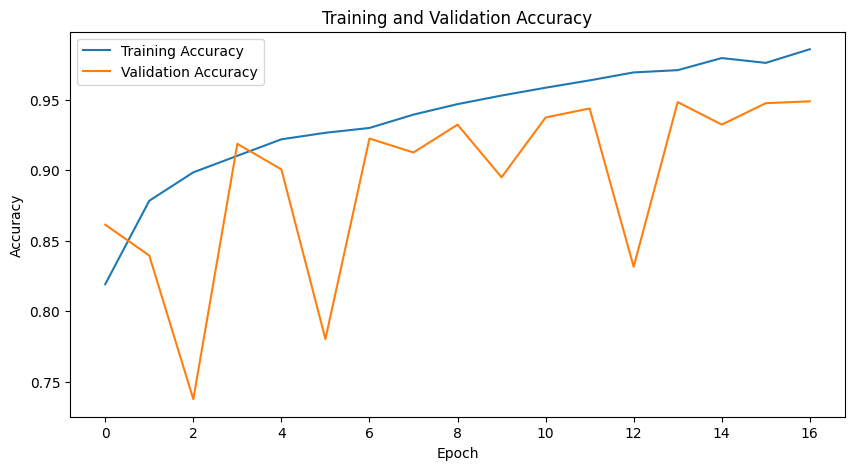

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


- TRAINING VS VALIDATION LOSS

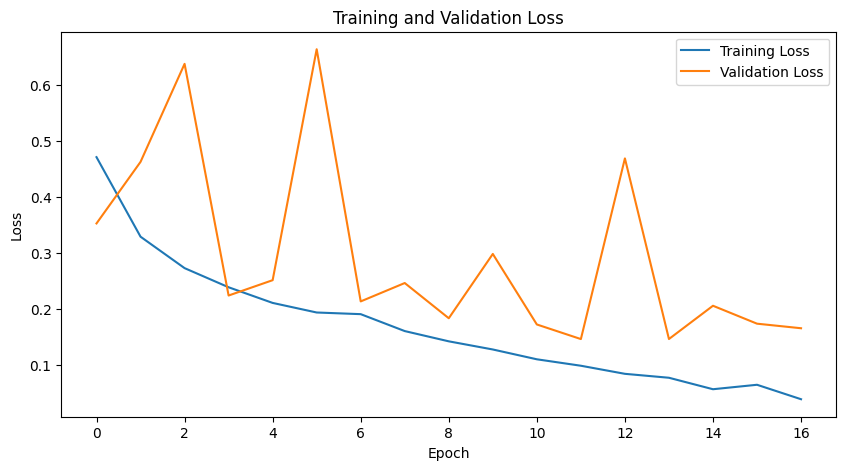

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


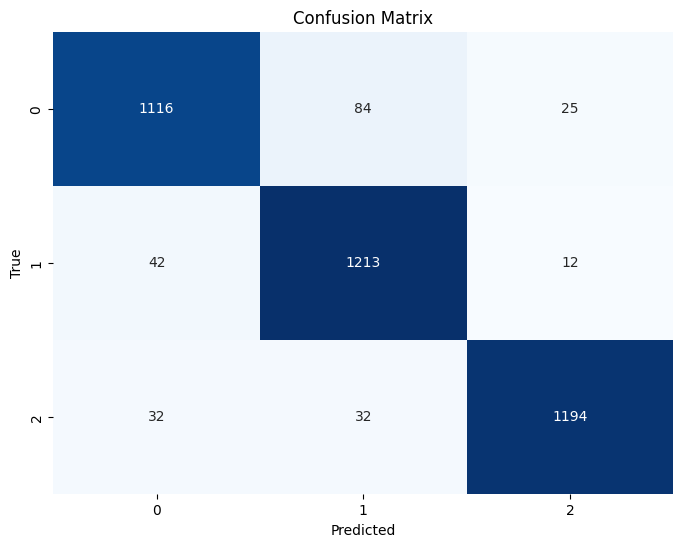

Precision: 0.9401
Recall: 0.9395
F1 Score: 0.9395


In [29]:
conf_matrix = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(test_targets, test_predictions, average='weighted')
recall = recall_score(test_targets, test_predictions, average='weighted')
f1 = f1_score(test_targets, test_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [30]:
torch.save(model.state_dict(), 'model2.h5')